<h1>Neural Translation Model in PyTorch</h1>
by Mac Brennan

<p style='text-align: center !important;'>
 <img src='https://github.com/macbrennan90/macbrennan90.github.io/blob/master/images/encoder-decoder.png?raw=true'
      alt='Translation Model Summary'>
</p>

This project will be broken up into several parts as follows:

__Part 1:__ Preparing the words

+ Inspecting the Dataset
+ Using Word Embeddings
+ Organizing the Data

__Part 2:__ Building the Model

+ Bi-Directional Encoder
+ Building Attention
+ Decoder with Attention

__Part 3:__ Training the Model

+ Training Function
+ Training Loop

__Part 4:__ Evaluation


This project closely follows the [PyTorch Sequence to Sequence tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html), while attempting to go more in depth with both the model implementation and the explanation. Thanks to [Sean Robertson](https://github.com/spro/practical-pytorch) and [PyTorch](https://pytorch.org/tutorials/) for providing such great tutorials.

If you are working through this notebook, it is strongly recommended that [Jupyter Notebook Extensions](https://github.com/ipython-contrib/jupyter_contrib_nbextensions) is installed so you can turn on collapsable headings. It makes the notebook much easier to navigate.

In [120]:
# Before we get started we will load all the packages we will need

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os.path
import time
import math
import random
import matplotlib.pyplot as plt
import string

# Use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [121]:
device

device(type='cuda')

## Part 1: Preparing the Words

### Inspecting the Dataset

The dataset that will be used is a text file of english sentences and the corresponding french sentences.

Each sentence is on a new line. The sentences will be split into a list.

#### Load the data
The data will be stored in two lists where each item is a sentence. The lists are:
+ english_sentences
+ french_sentences

Download the first dataset from the projects' github repo. Place it in the same folder as the notebook or create a data folder in the notebook's folder.

In [122]:
with open('data/small_vocab_en', "r") as f:
    data1 = f.read()
with open('data/small_vocab_fr', "r") as f:
    data2 = f.read()
    
# The data is just in a text file with each sentence on its own line
english_sentences = data1.split('\n')
french_sentences = data2.split('\n')

In [123]:
print('Number of English sentences:', len(english_sentences), 
      '\nNumber of French sentences:', len(french_sentences),'\n')
print('Example/Target pair:\n')
print('  '+english_sentences[2])
print('  '+french_sentences[2])

Number of English sentences: 137861 
Number of French sentences: 137861 

Example/Target pair:

  california is usually quiet during march , and it is usually hot in june .
  california est généralement calme en mars , et il est généralement chaud en juin .


#### Vocabulary
Let's take a closer look at the dataset.


In [124]:
english_sentences[2].split()

['california',
 'is',
 'usually',
 'quiet',
 'during',
 'march',
 ',',
 'and',
 'it',
 'is',
 'usually',
 'hot',
 'in',
 'june',
 '.']

In [125]:
max_en_length = 0
for sentence in english_sentences:
    length = len(sentence.split())
    max_en_length = max(max_en_length, length)
print("The longest english sentence in our dataset is:", max_en_length)    

The longest english sentence in our dataset is: 17


In [126]:
max_fr_length = 0
for sentence in french_sentences:
    length = len(sentence.split())
    max_fr_length = max(max_fr_length, length)
print("The longest french sentence in our dataset is:", max_fr_length)

The longest french sentence in our dataset is: 23


In [127]:
max_seq_length = max(max_fr_length, max_en_length) + 1
seq_length = max_seq_length

In [128]:
en_word_count = {}
fr_word_count = {}

for sentence in english_sentences:
    for word in sentence.split():
        if word in en_word_count:
            en_word_count[word] +=1
        else:
            en_word_count[word] = 1
            
for sentence in french_sentences:
    for word in sentence.split():
        if word in fr_word_count:
            fr_word_count[word] +=1
        else:
            fr_word_count[word] = 1


In [129]:
# Add end of sentence token to word count dict
en_word_count['</s>'] = len(english_sentences)
fr_word_count['</s>'] = len(english_sentences)

In [130]:
print('Number of unique English words:', len(en_word_count))
print('Number of unique French words:', len(fr_word_count))

Number of unique English words: 228
Number of unique French words: 356


In [131]:
def get_value(items_tuple):
    return items_tuple[1]

# Sort the word counts to see what words or most/least common
sorted_en_words= sorted(en_word_count.items(), key=get_value, reverse=True)

In [132]:
sorted_en_words[:10]

[('is', 205858),
 (',', 140897),
 ('</s>', 137861),
 ('.', 129039),
 ('in', 75525),
 ('it', 75137),
 ('during', 74933),
 ('the', 67628),
 ('but', 63987),
 ('and', 59850)]

In [133]:
sorted_fr_words = sorted(fr_word_count.items(), key=get_value, reverse=True)

In [134]:
sorted_fr_words[:10]

[('est', 196809),
 ('</s>', 137861),
 ('.', 135619),
 (',', 123135),
 ('en', 105768),
 ('il', 84079),
 ('les', 65255),
 ('mais', 63987),
 ('et', 59851),
 ('la', 49861)]

So the dataset is pretty small, we may want to get a bigger data set, but we'll see how this one does.

#### Alternate Dataset
Skip this section for now. You can come back and try training on this second dataset later. It is more diverse so it takes longer to train.

Download the French-English dataset from [here](http://www.manythings.org/anki/), Although you could train the model on any of the other language pairs. However, you would need different word embeddings or they would need to be trained from scratch.

In [160]:
with open('data/fra.txt', "r") as f:
    data1 = f.read()

In [161]:
pairs = data1.split('\n')
english_sentences = []
french_sentences = []
for i, pair in enumerate(pairs):
    pair_split = pair.split('\t')
    if len(pair_split)!= 2:
        continue
    english = pair_split[0].lower()
    french = pair_split[1].lower()
    
    # Remove punctuation and limit sentence length
    max_sent_length = 10
    punctuation_table = english.maketrans({i:None for i in string.punctuation})
    english = english.translate(punctuation_table)
    french = french.translate(punctuation_table)
    if len(english.split()) > max_sent_length or len(french.split()) > max_sent_length:
        continue
       
    english_sentences.append(english)
    french_sentences.append(french)

In [162]:
print(len(english_sentences), len(french_sentences))
english_sentences[10000].split()


139692 139692


['i', 'have', 'to', 'fight']

In [163]:
french_sentences[10000].split()

['il', 'me', 'faut', 'me', 'battre']

In [164]:
print(english_sentences[-100].split())
french_sentences[-100].split()


['would', 'you', 'consider', 'taking', 'care', 'of', 'my', 'children', 'next', 'saturday']


['pourriezvous',
 'réfléchir',
 'à',
 'vous',
 'occuper',
 'de',
 'mes',
 'enfants',
 'samedi',
 'prochain']

In [165]:
max_en_length = 0
for sentence in english_sentences:
    length = len(sentence.split())
    max_en_length = max(max_en_length, length)
print("The longest english sentence in our dataset is:", max_en_length)  

The longest english sentence in our dataset is: 10


In [166]:
max_fr_length = 0
for sentence in french_sentences:
    length = len(sentence.split())
    max_fr_length = max(max_fr_length, length)
print("The longest french sentence in our dataset is:", max_fr_length)  

The longest french sentence in our dataset is: 10


In [167]:
max_seq_length = max(max_fr_length, max_en_length) + 1
seq_length = max_seq_length

In [168]:
en_word_count = {}
fr_word_count = {}

for sentence in english_sentences:
    for word in sentence.split():
        if word in en_word_count:
            en_word_count[word] +=1
        else:
            en_word_count[word] = 1
            
for sentence in french_sentences:
    for word in sentence.split():
        if word in fr_word_count:
            fr_word_count[word] +=1
        else:
            fr_word_count[word] = 1


In [169]:
en_word_count['</s>'] = len(english_sentences)
fr_word_count['</s>'] = len(english_sentences)

In [170]:
print('Number of unique English words:', len(en_word_count))
print('Number of unique French words:', len(fr_word_count))

Number of unique English words: 12603
Number of unique French words: 25809


In [171]:
fr_word2idx = {k:v+3 for v, k in enumerate(fr_word_count.keys())}
en_word2idx = {k:v+3 for v, k in enumerate(en_word_count.keys())}

In [172]:
fr_word2idx['<pad>'] = 0
fr_word2idx['<s>'] = 1
fr_word2idx['<unk>'] = 2

en_word2idx['<pad>'] = 0
en_word2idx['<s>'] = 1
en_word2idx['<unk>'] = 2

In [173]:
len(fr_word2idx)

25812

In [174]:
def get_value(items_tuple):
    return items_tuple[1]

sorted_en_words= sorted(en_word_count.items(), key=get_value, reverse=True)

In [175]:
sorted_en_words[-10:]

[('impossibilities', 1),
 ('offers', 1),
 ('profound', 1),
 ('insights', 1),
 ('promoting', 1),
 ('domestically', 1),
 ('feat', 1),
 ('hummer', 1),
 ('limousines', 1),
 ('imprison', 1)]

### Using Word Embeddings

Here we are building an embedding matrix of pretrained word vectors. The word embeddings used here were downloaded from the [fastText repository](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md). These embeddings have 300 dimensions. To start we will add a few token embeddings for our specific case. We want a token to signal the start of the sentence, A token for words that we do not have an embedding for, and a token to pad sentences so all the sentences we use have the same length. This will allow us to train the model on batches of sentences that are different lengths, rather than one at a time.

After this step we will have a dictionary and an embedding matrix for each language. The dictionary will map words to an index value in the embedding matrix where its' corresponding embedding vector is stored.

#### Load Embeddings for the English data

In [176]:
# The data file containing the embeddings is very large so once we have the embeddings we want
# we will save them as a numpy array. This way we can load this much faster then having to re read from
# the large embedding file
if os.path.exists('data/en_words.npy') and os.path.exists('data/en_vectors.npy'):
    en_words = np.load('data/en_words.npy')
    en_vectors = np.load('data/en_vectors.npy')
    print('Embeddings load from .npy file')
else:
    # make a dict with the top 100,000 words
    en_words = ['<pad>', # Padding Token
                '<s>', # Start of sentence token
                '<unk>'# Unknown word token
               ]

    en_vectors = list(np.random.uniform(-0.1, 0.1, (3, 300)))
    en_vectors[0] *= 0 # make the padding vector zeros

    with open('data/wiki.en.vec', "r") as f:
        f.readline()
        for _ in range(100000):
            en_vecs = f.readline()
            word = en_vecs.split()[0]
            vector = np.float32(en_vecs.split()[1:])

            # skip lines that don't have 300 dim
            if len(vector) != 300:
                continue

            if word not in en_words:
                en_words.append(word)
                en_vectors.append(vector)
        print(word, vector[:10]) # Last word embedding read from the file
        en_words = np.array(en_words)
        en_vectors = np.array(en_vectors)
    # Save the arrays so we don't have to load the full word embedding file
    np.save('data/en_words.npy', en_words)
    np.save('data/en_vectors.npy', en_vectors)

Embeddings load from .npy file


In [177]:
en_word2idx = {word:index for index, word in enumerate(en_words)}

In [178]:
hemophilia_idx = en_word2idx['hemophilia']
print('index for word hemophilia:', hemophilia_idx, 
      '\nvector for word hemophilia:\n',en_vectors[hemophilia_idx][:10])

index for word hemophilia: 99996 
vector for word hemophilia:
 [ 0.16189    -0.056121   -0.65560001  0.21569    -0.11878    -0.02066
  0.37613001 -0.24117    -0.098989   -0.010058  ]


The word embedding for hemophilia matches the one read from the file, so it looks like everything worked properly.

#### Load Embeddings for the Frech data

In [179]:
if os.path.exists('data/fr_words.npy') and os.path.exists('data/fr_vectors.npy'):
    fr_words = np.load('data/fr_words.npy')
    fr_vectors = np.load('data/fr_vectors.npy')
    print('Embeddings load from .npy file')
else:
    # make a dict with the top 100,000 words
    fr_words = ['<pad>',
                '<s>',
                '<unk>']

    fr_vectors = list(np.random.uniform(-0.1, 0.1, (3, 300)))
    fr_vectors[0] = np.zeros(300) # make the padding vector zeros

    with open('data/wiki.fr.vec', "r") as f:
        f.readline()
        for _ in range(100000):
            fr_vecs = f.readline()
            word = fr_vecs.split()[0]
            try:
                vector = np.float32(fr_vecs.split()[1:])
            except ValueError:
                continue

             # skip lines that don't have 300 dim
            if len(vector) != 300:
                continue

            if word not in fr_words:
                fr_words.append(word)
                fr_vectors.append(vector)
        print(word, vector[:10])
        fr_words = np.array(fr_words)
        fr_vectors = np.array(fr_vectors)
    # Save the arrays so we don't have to load the full word embedding file
    np.save('data/fr_words.npy', fr_words)
    np.save('data/fr_vectors.npy', fr_vectors)

Embeddings load from .npy file


In [180]:
fr_word2idx = {word:index for index, word in enumerate(fr_words)}

In [181]:
chabeuil_idx = fr_word2idx['chabeuil']
print('index for word chabeuil:', chabeuil_idx, 
      '\nvector for word chabeuil:\n',fr_vectors[chabeuil_idx][:10])

index for word chabeuil: 99783 
vector for word chabeuil:
 [-0.18058001 -0.24758001  0.075607    0.17299999  0.24116001 -0.11223
 -0.28173     0.27373999  0.37997001  0.48008999]


In [182]:
fr_word2idx["chabeuil"]

99783

The word embedding for chabeuil matches as well so everything worked correctly for the french vocab.

Ok, so we have all the pieces needed to take words and convert them into word embeddings. These word embeddings already have a lot of useful information about how words relate since we loaded the pre-trained word embeddings. Now we can build the translation model with the embedding matrices built in.

### Setting up PyTorch Dataset and Dataloader

Rather than organizing all the data from a file and storing it in a list or some other data structure, PyTorch allows us to create a dataset object. To get an example from a dataset we just index the dataset object like we would a list. However, all our processing can be contained in the objects initialization or indexing process.

This will also make training easier when we want to iterate through batches.

In [183]:
class French2EnglishDataset(Dataset):
    '''
        French and associated English sentences.
    '''
    
    def __init__(self, fr_sentences, en_sentences, fr_word2idx, en_word2idx, seq_length):
        self.fr_sentences = fr_sentences
        self.en_sentences = en_sentences
        self.fr_word2idx = fr_word2idx
        self.en_word2idx = en_word2idx
        self.seq_length = seq_length
        self.unk_en = set()
        self.unk_fr = set()
    
    def __len__(self):
        return len(french_sentences)
    
    def __getitem__(self, idx):
        '''
            Returns a pair of tensors containing word indices
            for the specified sentence pair in the dataset.
        '''
        
        # init torch tensors, note that 0 is the padding index
        french_tensor = torch.zeros(self.seq_length, dtype=torch.long)
        english_tensor = torch.zeros(self.seq_length, dtype=torch.long)
        
        # Get sentence pair
        french_sentence = self.fr_sentences[idx].split()
        english_sentence = self.en_sentences[idx].split()
        
        # Add <EOS> tags
        french_sentence.append('</s>')
        english_sentence.append('</s>')
        
        # Load word indices
        for i, word in enumerate(french_sentence):
            if word in fr_word2idx and fr_word_count[word] > 5:
                french_tensor[i] = fr_word2idx[word]
            else:
                french_tensor[i] = fr_word2idx['<unk>']
                self.unk_fr.add(word)
        
        for i, word in enumerate(english_sentence):
            if word in en_word2idx and en_word_count[word] > 5:
                english_tensor[i] = en_word2idx[word]
            else:
                english_tensor[i] = en_word2idx['<unk>']
                self.unk_en.add(word)
            
        sample = {'french_tensor': french_tensor, 'french_sentence': self.fr_sentences[idx],
                  'english_tensor': english_tensor, 'english_sentence': self.en_sentences[idx]}
        return sample

In [184]:
french_english_dataset = French2EnglishDataset(french_sentences,
                                               english_sentences,
                                               fr_word2idx,
                                               en_word2idx,
                                               seq_length = seq_length)

#### Example output of dataset

In [185]:
test_sample = french_english_dataset[-10] # get 10th to last item in dataset

In [186]:
print('Input example:')
print('Sentence:', test_sample['french_sentence'])
print('Tensor:', test_sample['french_tensor'])

print('\nTarget example:')
print('Sentence:', test_sample['english_sentence'])
print('Tensor:', test_sample['english_tensor'])

Input example:
Sentence: la station spatiale internationale est une étonnante prouesse technologique
Tensor: tensor([   9,  787,    2,  730,   21,   23,    2,    2,    2,    3,
           0])

Target example:
Sentence: the international space station is an amazing feat of engineering
Tensor: tensor([    5,   214,   657,   309,    16,    32,  6425,     2,     7,
            2,     6])


In [187]:
# Check that both tensors end with the end of sentence token
print(fr_word2idx['</s>'])
en_word2idx['</s>']

3


6

In [188]:
# Build dataloader to check how the batching works
dataloader = DataLoader(french_english_dataset, batch_size=5,
                        shuffle=True, num_workers=4)

In [193]:
# Prints out 10 batches from the dataloader
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['french_tensor'].shape,
          sample_batched['english_tensor'].shape)
    if i_batch == 3:
        break

0 torch.Size([5, 11]) torch.Size([5, 11])
1 torch.Size([5, 11]) torch.Size([5, 11])
2 torch.Size([5, 11]) torch.Size([5, 11])
3 torch.Size([5, 11]) torch.Size([5, 11])


In [194]:
for i in dataloader:
    batch = i
    break

for i in range(5):
    print('French Sentence:', batch['french_sentence'][i])
    print('English Sentence:', batch['english_sentence'][i],'\n')

French Sentence: je vais laver les plats
English Sentence: ill wash dishes 

French Sentence: les nouvelles les rendirent heureux
English Sentence: the news made them happy 

French Sentence: globalement la conférence internationale fut un succès
English Sentence: all in all the international conference was a success 

French Sentence: comment marche cet appareil photo 
English Sentence: how do you use this camera 

French Sentence: cest ton jour de chance
English Sentence: this is your lucky day 



## Part 2: Building the Model

### Bi-Directional Encoder

In [114]:
class EncoderBiLSTM(nn.Module):
    def __init__(self, hidden_size, pretrained_embeddings):
        super(EncoderBiLSTM, self).__init__()
        
        # Model Parameters
        self.hidden_size = hidden_size
        self.embedding_dim = pretrained_embeddings.shape[1]
        self.vocab_size = pretrained_embeddings.shape[0]
        self.num_layers = 2
        self.dropout = 0.1 if self.num_layers > 1 else 0
        self.bidirectional = True
        
        
        # Construct the layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings)) #Load the pretrained embeddings
        self.embedding.weight.requires_grad = False #Freeze embedding layer
        
        self.lstm = nn.LSTM(self.embedding_dim,
                            self.hidden_size,
                            self.num_layers,
                            batch_first = True,
                            dropout=self.dropout,
                            bidirectional=self.bidirectional)
        
        # Initialize hidden to hidden weights in LSTM to the Identity matrix
        # This improves training and prevents exploding gradients
        # PyTorch LSTM has the 4 different hidden to hidden weights stacked in one matrix
        identity_init = torch.eye(self.hidden_size)
        self.lstm.weight_hh_l0.data.copy_(torch.cat([identity_init]*4, dim=0))
        self.lstm.weight_hh_l0_reverse.data.copy_(torch.cat([identity_init]*4, dim=0))
        self.lstm.weight_hh_l1.data.copy_(torch.cat([identity_init]*4, dim=0))
        self.lstm.weight_hh_l1_reverse.data.copy_(torch.cat([identity_init]*4, dim=0))
    
    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = self.lstm(embedded, hidden)
        return output
    
    def initHidden(self, batch_size):
        
        hidden_state = torch.zeros(self.num_layers*(2 if self.bidirectional else 1),
                                   batch_size,
                                   self.hidden_size, 
                                   device=device)
        
        cell_state = torch.zeros(self.num_layers*(2 if self.bidirectional else 1),
                                 batch_size,
                                 self.hidden_size, 
                                 device=device)
        
        return (hidden_state, cell_state)

In [115]:
class EncoderBiGRU(nn.Module):
    def __init__(self, hidden_size, pretrained_embeddings):
        super(EncoderBiGRU, self).__init__()
        
        # Model parameters
        self.hidden_size = hidden_size
        self.embedding_dim = pretrained_embeddings.shape[1]
        self.vocab_size = pretrained_embeddings.shape[0]
        self.num_layers = 2
        self.dropout = 0.1 if self.num_layers > 1 else 0
        self.bidirectional = True
        
        
        # Construct the layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        self.embedding.weight.requires_grad = False
        
        self.gru = nn.GRU(self.embedding_dim,
                            self.hidden_size,
                            self.num_layers,
                            batch_first = True,
                            dropout=self.dropout,
                            bidirectional=self.bidirectional)
        
        # Initialize hidden to hidden weights in GRU to the Identity matrix
        # PyTorch GRU has 3 different hidden to hidden weights stacked in one matrix
        identity_init = torch.eye(self.hidden_size)
        self.gru.weight_hh_l0.data.copy_(torch.cat([identity_init]*3, dim=0))
        self.gru.weight_hh_l0_reverse.data.copy_(torch.cat([identity_init]*3, dim=0))
        self.gru.weight_hh_l1.data.copy_(torch.cat([identity_init]*3, dim=0))
        self.gru.weight_hh_l1_reverse.data.copy_(torch.cat([identity_init]*3, dim=0))
    
    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = self.gru(embedded, hidden)
        return output
    
    def initHidden(self, batch_size):
        
        hidden_state = torch.zeros(self.num_layers*(2 if self.bidirectional else 1),
                                   batch_size,
                                   self.hidden_size, 
                                   device=device)
        
        return hidden_state

#### Testing the Encoder

In [32]:
# Test the encoder on a sample input, input tensor has dimensions (batch_size, seq_length)

batch_size = 1
seq_length = 3
hidden_size = 5
encoder = EncoderBiLSTM(hidden_size, fr_vectors).to(device)
hidden = encoder.initHidden(batch_size)

# Create an input tensor of random indices
inputs = torch.randint(0, 50, (batch_size, seq_length), dtype=torch.long, device=device)

encoder_output, hidden_state = encoder.forward(inputs, hidden)

print("The final output of the BiLSTM Encoder on our test input is: \n\n", encoder_output.shape)

print('\n\nEncoder output tensor: \n\n', encoder_output)

RuntimeError: cuda runtime error (46) : all CUDA-capable devices are busy or unavailable at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/THCTensorRandom.cu:25

In [ ]:
hidden_state# Tuple where first item is the hidden states, second item is the cell states.

# The lstm has 2 layers, each layer has a forward and backward pass giving 4

In [33]:
hidden_state[0][::2] # Hidden states from forward pass for both lstm layers.

NameError: name 'hidden_state' is not defined

In [102]:
encoder_gru = EncoderBiGRU(hidden_size, fr_vectors).to(device)
hidden = encoder_gru.initHidden(batch_size)
o,h = encoder_gru(inputs, hidden)

In [103]:
o

tensor([[[-0.0655,  0.1603, -0.0524, -0.0657, -0.1401,  0.3061,  0.2582,
           0.0695, -0.2592,  0.5090],
         [ 0.0141, -0.0763, -0.0059, -0.0959, -0.1177,  0.2653,  0.1059,
          -0.0114, -0.2287,  0.4691],
         [ 0.0666, -0.1238, -0.0988, -0.0869, -0.2081,  0.1008,  0.0713,
           0.0013, -0.1661,  0.2408]]], device='cuda:0')

In [110]:
print(h)
h[1::2]

tensor([[[ 0.5315, -0.1505,  0.1251,  0.5621,  0.2153]],

        [[ 0.0974,  0.6534, -0.4232,  0.2435, -0.3140]],

        [[ 0.0666, -0.1238, -0.0988, -0.0869, -0.2081]],

        [[ 0.3061,  0.2582,  0.0695, -0.2592,  0.5090]]], device='cuda:0')


tensor([[[ 0.0974,  0.6534, -0.4232,  0.2435, -0.3140]],

        [[ 0.3061,  0.2582,  0.0695, -0.2592,  0.5090]]], device='cuda:0')

### Attention
Let's take a moment test how attention is being modeled. Weighted sum of sequence items from encoder output.

In [39]:
# Initialize attention weights to one, note the dimensions
attn_weights = torch.ones((batch_size, seq_length),device=device)

# Set all weights except the weights associated with the first sequence item equal to zero
# This would represent full attention on the first word in the sequence
attn_weights[:, 1:] = 0

attn_weights.unsqueeze_(1) # Add dimension for batch matrix multiplication

# BMM(Batch Matrix Multiply) muliplies the [1 x seq_length] matrix by the [seq_length x hidden_size] matrix for
# each batch. This produces a single vector(for each batch) of length(encoder_hidden_size) that is the weighted
# sum of the encoder hidden vectors for each item in the sequence.
attn_applied = torch.bmm(attn_weights, encoder_output)
attn_applied.squeeze_() # Remove extra dimension

print('Attention weights:\n', attn_weights)
print('\nFirst sequence item in Encoder output: \n',encoder_output[:,0,:])
print('\nEncoder Output after attention is applied: \n', attn_applied)
print('\n', attn_applied.shape)

Attention weights:
 tensor([[[ 1.,  0.,  0.]]], device='cuda:0')

First sequence item in Encoder output: 
 tensor([[ 0.0148, -0.0507,  0.0720,  0.1213, -0.0374,  0.2630, -0.0217,
         -0.1557,  0.1702, -0.1133]], device='cuda:0')

Encoder Output after attention is applied: 
 tensor([ 0.0148, -0.0507,  0.0720,  0.1213, -0.0374,  0.2630, -0.0217,
        -0.1557,  0.1702, -0.1133], device='cuda:0')

 torch.Size([10])


### Decoder with Attention

In [116]:
class AttnDecoderLSTM(nn.Module):
    def __init__(self, decoder_hidden_size, pretrained_embeddings, seq_length):
        super(AttnDecoderLSTM, self).__init__()
        # Embedding parameters
        self.embedding_dim = pretrained_embeddings.shape[1]
        self.output_vocab_size = pretrained_embeddings.shape[0]
        
        # LSTM parameters
        self.decoder_hidden_size = decoder_hidden_size
        self.num_layers = 2 # Potentially add more layers to LSTM later
        self.dropout = 0.1 if self.num_layers > 1 else 0 # Potentially add dropout later
        
        # Attention parameters
        self.seq_length = seq_length
        self.encoder_hidden_dim = 2*decoder_hidden_size
        
        # Construct embedding layer for output language
        self.embedding = nn.Embedding(self.output_vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        self.embedding.weight.requires_grad = False # we don't want to train the embedding weights
        
        # Construct layer that calculates attentional weights
        self.attn = nn.Linear((self.decoder_hidden_size + self.embedding_dim), self.seq_length)
        
        # Construct layer that compresses the combined matrix of the input embeddings
        # and the encoder inputs after attention has been applied
        self.attn_with_input = nn.Linear(self.embedding_dim + self.encoder_hidden_dim, self.embedding_dim)
        
        # LSTM for Decoder
        self.lstm = nn.LSTM(self.embedding_dim,
                            self.decoder_hidden_size,
                            self.num_layers,
                            dropout=self.dropout)
        
        # Initialize hidden to hidden weights in LSTM to the Identity matrix
        # PyTorch LSTM has 4 different hidden to hidden weights stacked in one matrix
        identity_init = torch.eye(self.decoder_hidden_size)
        self.lstm.weight_hh_l0.data.copy_(torch.cat([identity_init]*4, dim=0))
        self.lstm.weight_hh_l1.data.copy_(torch.cat([identity_init]*4, dim=0))
        
        # Output layer
        self.out = nn.Linear(self.decoder_hidden_size, self.output_vocab_size)
    
    def forward(self, input, hidden, encoder_output):
        # Input word indices, should have dim(1, batch_size), output will be (1, batch_size, embedding_dim)
        embedded = self.embedding(input)
        
        # Calculate Attention weights
        attn_weights = F.softmax(self.attn(torch.cat((hidden[0][1], embedded[0]), 1)), dim=1)
        attn_weights = attn_weights.unsqueeze(1) # Add dimension for batch matrix multiplication
        
        # Apply Attention weights
        attn_applied = torch.bmm(attn_weights, encoder_output)
        attn_applied = attn_applied.squeeze(1) # Remove extra dimension, dim are now (batch_size, encoder_hidden_size)
        
        # Prepare LSTM input tensor
        attn_combined = torch.cat((embedded[0], attn_applied), 1) # Combine embedding input and attn_applied,
        lstm_input = F.relu(self.attn_with_input(attn_combined)) # pass through fully connected with ReLU
        lstm_input = lstm_input.unsqueeze(0) # Add seq dimension so tensor has expected dimensions for lstm
        
        output, hidden = self.lstm(lstm_input, hidden) # Output dim = (1, batch_size, decoder_hidden_size)
        output = F.log_softmax(self.out(output[0]), dim=1) # softmax over all words in vocab
        
        
        return output, hidden, attn_weights

In [117]:
class AttnDecoderGRU(nn.Module):
    def __init__(self, decoder_hidden_size, pretrained_embeddings, seq_length):
        super(AttnDecoderGRU, self).__init__()
        # Embedding parameters
        self.embedding_dim = pretrained_embeddings.shape[1]
        self.output_vocab_size = pretrained_embeddings.shape[0]
        
        # GRU parameters
        self.decoder_hidden_size = decoder_hidden_size
        self.num_layers = 2 # Potentially add more layers to LSTM later
        self.dropout = 0.1 if self.num_layers > 1 else 0 # Potentially add dropout later
        
        # Attention parameters
        self.seq_length = seq_length
        self.encoder_hidden_dim = 2*decoder_hidden_size
        
        # Construct embedding layer for output language
        self.embedding = nn.Embedding(self.output_vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        self.embedding.weight.requires_grad = False # we don't want to train the embedding weights
        
        # Construct layer that calculates attentional weights
        self.attn = nn.Linear(self.decoder_hidden_size + self.embedding_dim, self.seq_length)
        
        # Construct layer that compresses the combined matrix of the input embeddings
        # and the encoder inputs after attention has been applied
        self.attn_with_input = nn.Linear(self.embedding_dim + self.encoder_hidden_dim, self.embedding_dim)
        
        # gru for Decoder
        self.gru = nn.GRU(self.embedding_dim,
                            self.decoder_hidden_size,
                            self.num_layers,
                            dropout=self.dropout)
        
        # Initialize hidden to hidden weights in GRU to the Identity matrix
        # PyTorch GRU has 3 different hidden to hidden weights stacked in one matrix
        identity_init = torch.eye(self.decoder_hidden_size)
        self.gru.weight_hh_l0.data.copy_(torch.cat([identity_init]*3, dim=0))
        self.gru.weight_hh_l1.data.copy_(torch.cat([identity_init]*3, dim=0))
        
        # Output layer
        self.out = nn.Linear(self.decoder_hidden_size, self.output_vocab_size)
    
    def forward(self, input, hidden, encoder_output):
        # Input word indices, should have dim(1, batch_size), output will be (1, batch_size, embedding_dim)
        embedded = self.embedding(input)
        
        # Calculate Attention weights
        attn_weights = F.softmax(self.attn(torch.cat((hidden[0], embedded[0]), 1)), dim=1)
        attn_weights = attn_weights.unsqueeze(1) # Add dimension for batch matrix multiplication
        
        # Apply Attention weights
        attn_applied = torch.bmm(attn_weights, encoder_output)
        attn_applied = attn_applied.squeeze(1) # Remove extra dimension, dim are now (batch_size, encoder_hidden_size)
        
        # Prepare GRU input tensor

        attn_combined = torch.cat((embedded[0], attn_applied), 1) # Combine embedding input and attn_applied,
        gru_input = F.relu(self.attn_with_input(attn_combined)) # pass through fully connected with ReLU
        gru_input = gru_input.unsqueeze(0) # Add seq dimension so tensor has expected dimensions for lstm
        
        output, hidden = self.gru(gru_input, hidden) # Output dim = (1, batch_size, decoder_hidden_size)
        output = F.log_softmax(self.out(output[0]), dim=1) # softmax over all words in vocab
        
        return output, hidden, attn_weights

#### Testing the Decoder

In [42]:
# Test the decoder on sample inputs to check that the dimensions of everything is correct
decoder_hidden_size = 5

decoder = AttnDecoderLSTM(decoder_hidden_size, en_vectors, seq_length, 2*hidden_size).to(device)

In [43]:
input_idx = torch.tensor([fr_word2idx['<s>']]*batch_size, dtype=torch.long, device=device)

In [44]:
input_idx.shape

torch.Size([1])

In [45]:
input_idx = input_idx.unsqueeze_(0)
decoder_hidden = decoder.initHidden(batch_size)

In [46]:
input_idx.shape

torch.Size([1, 1])

In [48]:
output, hidden, attention = decoder.forward(input_idx, decoder_hidden, encoder_output)
print(output.shape)

torch.Size([1, 99997])


In [49]:
decoder_hidden[0].shape

torch.Size([2, 1, 5])

## Part 3: Training the Model

### Training Function

In [118]:
def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion):
    
    # Initialize encoder hidden state
    encoder_hidden = encoder.initHidden(input_tensor.shape[0])
    
    # clear the gradients in the optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # run forward pass through encoder on entire sequence
    encoder_output, encoder_hidden = encoder.forward(input_tensor, encoder_hidden)
    
    # Initialize decoder input(Start of Sentence tag) and hidden state from encoder
    decoder_input =  torch.tensor([en_word2idx['<s>']]*input_tensor.shape[0], dtype=torch.long, device=device).unsqueeze(0)
    
    # Use correct initial hidden state dimensions depending on type of RNN
    try:
        encoder.lstm
        decoder_hidden = (encoder_hidden[0][1::2].contiguous(), encoder_hidden[1][1::2].contiguous())
    except AttributeError:
        decoder_hidden = encoder_hidden[1::2].contiguous()
    
    # Initialize loss
    loss = 0
    
    # Implement teacher forcing
    use_teacher_forcing = True if random.random() < 0.5 else False

    if use_teacher_forcing:
        # Step through target output sequence
        for di in range(seq_length):
            output, decoder_hidden, attn_weights = decoder(decoder_input,
                                                           decoder_hidden,
                                                           encoder_output)
            
            # Feed target as input to next item in the sequence
            decoder_input = target_tensor[di].unsqueeze(0)
            loss += criterion(output, target_tensor[di])
    else:
        # Step through target output sequence
        for di in range(seq_length):
            
            # Forward pass through decoder
            output, decoder_hidden, attn_weights = decoder(decoder_input,
                                                           decoder_hidden,
                                                           encoder_output)
            
            # Feed output as input to next item in the sequence
            decoder_input = output.topk(1)[1].view(1,-1).detach()
            
            # Calculate loss
            loss += criterion(output, target_tensor[di])
    
    # Compute the gradients
    loss.backward()
    
    # Clip the gradients
    nn.utils.clip_grad_norm_(encoder.parameters(), 25)
    nn.utils.clip_grad_norm_(decoder.parameters(), 25)
    
    # Update the weights
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()

### Training Loop

In [119]:
def trainIters(encoder, decoder, dataloader, epochs, print_every_n_batches=100, learning_rate=0.01):
    
    # keep track of losses
    plot_losses = []

    # Initialize Encoder Optimizer
    encoder_parameters = filter(lambda p: p.requires_grad, encoder.parameters())
    encoder_optimizer = optim.Adam(encoder_parameters, lr=learning_rate)
    
    # Initialize Decoder Optimizer
    decoder_parameters = filter(lambda p: p.requires_grad, decoder.parameters())
    decoder_optimizer = optim.Adam(decoder_parameters, lr=learning_rate)

    # Specify loss function, ignore the <pad> token index so it does not contribute to loss.
    criterion = nn.NLLLoss(ignore_index=0)
    
    # Cycle through epochs
    for epoch in range(epochs):
        loss_avg = 0
        print(f'Epoch {epoch + 1}/{epochs}')
        # Cycle through batches
        for i, batch in enumerate(dataloader):
            
            input_tensor = batch['french_tensor'].to(device)
            target_tensor = batch['english_tensor'].transpose(1,0).to(device)
            

            loss = train(input_tensor, target_tensor, encoder, decoder,
                         encoder_optimizer, decoder_optimizer, criterion)
            
            loss_avg += loss
            if i % print_every_n_batches == 0 and i != 0:
                loss_avg /= print_every_n_batches
                print(f'After {i} batches, average loss/{print_every_n_batches} batches: {loss_avg}')
                plot_losses.append(loss)
                loss_avg = 0
    return plot_losses

### Training the Model

In [61]:
# Set hyperparameters and construct dataloader
hidden_size = 256
batch_size = 16
dataloader = DataLoader(french_english_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=4) 

In [62]:
# Construct encoder and decoder instances
encoder_lstm = EncoderBiLSTM(hidden_size, fr_vectors).to(device)
decoder_lstm = AttnDecoderLSTM(hidden_size, en_vectors, seq_length).to(device)

encoder_gru = EncoderBiGRU(hidden_size, fr_vectors).to(device)
decoder_gru = AttnDecoderGRU(hidden_size, en_vectors, seq_length).to(device)

In [63]:
from_scratch = True # Set to False if you have saved weights and want to load them

if not from_scratch:
    # Load weights from earlier model
    encoder_lstm_state_dict = torch.load('models/encoder2_lstm.pth')
    decoder_lstm_state_dict = torch.load('models/decoder2_lstm.pth')

    encoder_lstm.load_state_dict(encoder_lstm_state_dict)
    decoder_lstm.load_state_dict(decoder_lstm_state_dict)
    
        # Load weights from earlier model
    encoder_gru_state_dict = torch.load('models/encoder2_gru.pth')
    decoder_gru_state_dict = torch.load('models/decoder2_gru.pth')

    encoder_gru.load_state_dict(encoder_gru_state_dict)
    decoder_gru.load_state_dict(decoder_gru_state_dict)
else:
    print('Training model from scratch.')

Training model from scratch.


In [64]:
# For dataset 1, models were trained for 3 epochs
# For dataset 2, models were trained for 50 epochs
epochs = 3

learning_rate = 0.01
encoder_lstm.train() # Set model to training mode
decoder_lstm.train() # Set model to training mode

lstm_losses = trainIters(encoder_lstm, decoder_lstm, dataloader, epochs=epochs, learning_rate = learning_rate)

print('Training GRU based network.')
learning_rate = 0.001
encoder_gru.train() # Set model to training mode
decoder_gru.train() # Set model to training mode

gru_losses = trainIters(encoder_gru, decoder_gru, dataloader, epochs=epochs, learning_rate = learning_rate)

Epoch 1/10
After 100 batches, average loss/100 batches: 62.748027305603024
After 200 batches, average loss/100 batches: 41.63469253540039
After 300 batches, average loss/100 batches: 34.82304986953736
After 400 batches, average loss/100 batches: 29.68024871826172
After 500 batches, average loss/100 batches: 26.780836715698243
After 600 batches, average loss/100 batches: 23.958564376831056
After 700 batches, average loss/100 batches: 23.794751720428465
After 800 batches, average loss/100 batches: 21.266270446777344
After 900 batches, average loss/100 batches: 19.668433570861815
After 1000 batches, average loss/100 batches: 19.321900453567505
After 1100 batches, average loss/100 batches: 18.807011852264406
After 1200 batches, average loss/100 batches: 17.880580081939698
After 1300 batches, average loss/100 batches: 18.17206443786621
After 1400 batches, average loss/100 batches: 16.755054712295532
After 1500 batches, average loss/100 batches: 15.928379106521607
After 1600 batches, average

After 4300 batches, average loss/100 batches: 8.658493566513062
After 4400 batches, average loss/100 batches: 7.658784246444702
After 4500 batches, average loss/100 batches: 8.233843302726745
After 4600 batches, average loss/100 batches: 8.126086649894715
After 4700 batches, average loss/100 batches: 7.7272272968292235
After 4800 batches, average loss/100 batches: 6.997283596992492
After 4900 batches, average loss/100 batches: 7.12559374332428
After 5000 batches, average loss/100 batches: 7.548875374794006
After 5100 batches, average loss/100 batches: 8.838353657722473
After 5200 batches, average loss/100 batches: 8.196422944068908
After 5300 batches, average loss/100 batches: 8.352819991111755
After 5400 batches, average loss/100 batches: 7.767843008041382
After 5500 batches, average loss/100 batches: 8.87916738986969
After 5600 batches, average loss/100 batches: 8.81864176273346
After 5700 batches, average loss/100 batches: 8.580280404090882
After 5800 batches, average loss/100 batch

Process Process-42:
Process Process-41:
Process Process-43:
Process Process-44:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mac/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mac/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/mac/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mac/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/mac/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mac/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File

KeyboardInterrupt: 

In [ ]:
np.save('data/lstm1_losses.npy', lstm_losses)

In [196]:
np.save('data/gru1_losses.npy', gru_losses)

In [87]:
lstm2_losses = np.load('data/lstm2_losses.npy')
gru2_losses = np.load('data/gru2_losses.npy')

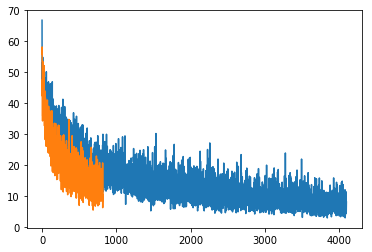

In [89]:
plt.plot(gru2_losses)
plt.plot(lstm2_losses)

In [197]:
# Save the model weights to continue later
torch.save(encoder_lstm.state_dict(), 'models/encoder1_lstm.pth')
torch.save(decoder_lstm.state_dict(), 'models/decoder1_lstm.pth')

In [47]:
torch.save(encoder_gru.state_dict(), 'models/encoder1_gru.pth')
torch.save(decoder_gru.state_dict(), 'models/decoder1_gru.pth')

## Part 4: Using the Model for Evaluation

In [90]:
# Build the idx to word dictionaries to convert predicted indices to words
en_idx2word = {k:i for i, k in en_word2idx.items()}
fr_idx2word = {k:i for i, k in fr_word2idx.items()}

In [91]:
def get_batch(dataloader):
    for batch in dataloader:
        return batch

In [92]:
def evaluate(input_tensor, encoder, decoder):
    with torch.no_grad():
        encoder_hidden = encoder.initHidden(1)
        encoder.eval()
        decoder.eval()

        encoder_output, encoder_hidden = encoder(input_tensor.to(device), encoder_hidden)

        decoder_input =  torch.tensor([fr_word2idx['<s>']]*input_tensor.shape[0], dtype=torch.long, device=device).unsqueeze(0)
        try:
            encoder.lstm
            decoder_hidden = (encoder_hidden[0][1::2].contiguous(), encoder_hidden[1][1::2].contiguous())
        except AttributeError:
            decoder_hidden = encoder_hidden[1::2].contiguous()

        output_list = []
        attn_weight_list = np.zeros((seq_length, seq_length))
        for di in range(seq_length):
            output, decoder_hidden, attn_weights = decoder(decoder_input,
                                                           decoder_hidden,
                                                           encoder_output)

            decoder_input = output.topk(1)[1].detach()
            output_list.append(output.topk(1)[1])
            word = en_idx2word[output.topk(1)[1].item()]

            attn_weight_list[di] += attn_weights[0,0,:].cpu().numpy()
        return output_list, attn_weight_list

In [156]:
batch = get_batch(dataloader)
input_tensor = batch['french_tensor'][11].unsqueeze_(0)
output_list, attn = evaluate(input_tensor, encoder_lstm, decoder_lstm)
gru_output_list, gru_attn = evaluate(input_tensor, encoder_gru, decoder_gru)

Input Sentence:
 <unk> ta bonne santé </s>

Target Sentence:
 i envy your good health</s>

LSTM model output:
 i admire your health </s>

GRU model output:
 i hope your health health </s>


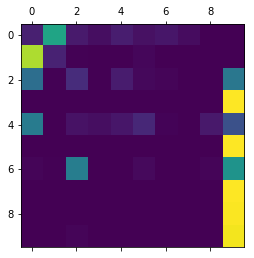

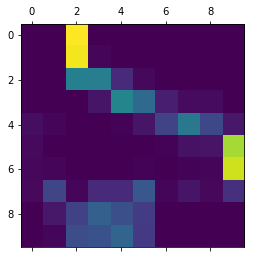

In [157]:
print('Input Sentence:')
output = ''
for index in input_tensor[0]:
    word = fr_idx2word[index.item()]
    if word != '</s>':
        output += ' ' + word
    else:
        output += ' ' + word
        print(output)
        break

print('\nTarget Sentence:')
print(' ' + batch['english_sentence'][11] + '</s>')

print('\nLSTM model output:')
output = ''
for index in output_list:
    word = en_idx2word[index.item()]
    if word != '</s>':
        output += ' ' + word
    else:
        output += ' ' + word
        print(output)
        break

output = ''
print('\nGRU model output:')
for index in gru_output_list:
    word = en_idx2word[index.item()]
    if word != '</s>':
        output += ' ' + word
    else:
        output += ' ' + word
        print(output)
        break
        
plt.matshow(attn)
plt.matshow(gru_attn)